# Deep Learning Project Derek & Kamiel
## 0) Install and load libraries



In [0]:
!pip install mxnet-cu101==1.6.0b20191122

import mxnet
from mxnet import gluon, npx, np, autograd
from mxnet.gluon import nn
import os, shutil, zipfile
#from git import Repo
import pandas as pd
import random
import PIL.Image
import matplotlib
import time
import mxnet.gluon.data.vision as vision
import matplotlib.pyplot as plt
from statistics import mean
import math

! pip install d2l -q
import d2l

## 1) Download the data
This template downloads the UCM data (both mono and multi-labels) in your local Colab environment. Write the notebook in such a way that it fully runs from start to end without further intervention (i.e. do not change the directory structure manually in the mean time).

In [0]:
if os.path.isdir('ucmdata'):
  ! rm -rf ucmdata

! git clone https://git.wur.nl/lobry001/ucmdata.git
os.chdir('ucmdata')

with zipfile.ZipFile('UCMerced_LandUse.zip', 'r') as zip_ref:
    zip_ref.extractall('UCMImages')

!mv UCMImages/UCMerced_LandUse/Images .
!rm -rf UCMImages README.md  UCMerced_LandUse.zip
!ls

UCM_images_path = "Images/"
Multilabels_path = "LandUse_Multilabeled.txt"

Cloning into 'ucmdata'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.
Images	LandUse_Multilabeled.txt


In [0]:
## ============== Function to split data paths in train/test for data loading =========================

def convert_and_split(parent_dir, split_ratio = 0.8, n_copies = 1):
    ''' randomly split all filenames in a parent directory into a test and a train set AND copy them to their respective directories
    parent_dir = pathname of the parent directory
    split_ratio = train/test ratio, default of 0.8 will give 80% train, 20% test
    '''
    # walk through the parent dir and find all file paths that are not hidden files
    listOfFiles = list()
    dirs = []

    for root, directories, filenames in os.walk(parent_dir):
        if not dirs: # save a list of class directories
            dirs = directories
        for i, filename in enumerate(filenames):
            if not filename.startswith('.'):
                  path = os.path.join(root, filename)
                  if not path.endswith('.PNG'):
                      im = PIL.Image.open(path)
                      im.save(path.split('.')[0] + '.PNG', 'PNG', quality=100)
                      os.remove(path)
                      path = path.split('.')[0] + '.PNG'
                  listOfFiles += [path]

    # Multiply the images
    if n_copies >= 1:
        for root, directories, filenames in os.walk(parent_dir):
            for filename in filenames:
                src = os.path.join(root, filename)
                base = ''.join(i for i in os.path.basename(src).split('.')[0] if not i.isdigit())
                filenr =  ''.join(i for i in os.path.basename(src).split('.')[0] if i.isdigit())
                ext = ''.join(i for i in os.path.basename(src).split('.')[1])

                for i in range(n_copies):
                    new = root + "/" + base + filenr + str(i) + '.' + ext
                    shutil.copy(src, new)
                    listOfFiles += [new]

               

    # shuffle list of file paths and split according to the split ratio
    random.shuffle(listOfFiles)

    # create folder structure for test and train data
    for mode in ['train', 'test']:
        if not os.path.exists(mode):
            os.mkdir(mode)
            [os.mkdir(os.path.join(mode, dir)) for dir in dirs]

    for i, path in enumerate(listOfFiles):
        mode = "train" if i < round(len(listOfFiles) * split_ratio) else "test"
        file = os.path.split(path)[1]
        file_dir = ''.join(filter(lambda x: x.isalpha(), file.split('.')[0]))
        os.rename(path, os.path.join(mode, file_dir, file))

    return
! rm -rf train
! rm -rf test
! ls
n_copies = 5 # cannot be larger than 9 in current code implementation
convert_and_split(parent_dir = UCM_images_path, n_copies=n_copies)

Images	LandUse_Multilabeled.txt


In [0]:
## ============== DEFINING THE MULTILABEL DATASET CLASS ===================
class Dataset_Multilabel(gluon.data.Dataset):
    def __init__(self, folder, label_file, dim=256, ch=3, transform=None, n_copies=3):
        super(Dataset_Multilabel, self).__init__()
        self.rgb_mean = mxnet.nd.array([0.485, 0.456, 0.406])
        self.rgb_std = mxnet.nd.array([0.229, 0.224, 0.225])

        # count the number of files in the folder       
        nfiles = sum([len(files) for r, d, files in os.walk(folder)])

        # Load labels as dataframe, define number of classes
        label_df = pd.read_csv(label_file, sep="\t")
        nclasses = len(label_df.columns) - 1

        # initialize arrays
        self.imgs = mxnet.nd.empty((nfiles, ch, dim, dim))
        self.labels = mxnet.nd.empty((nfiles, nclasses))
        cnt = 0
        # Define self.images
        for root, dirs, filenames in os.walk(folder):
            for filename in filenames:
              if not filename.startswith('.'):
                  path = os.path.join(root, filename)
                  img = mxnet.image.image.imread(path).astype('float32') / 255
                  if transform:
                      img = transform(img)
                  else:
                      img = img.transpose(axes=(2, 0, 1))

                  self.imgs[cnt] = img
                  label = label_df.loc[label_df['IMAGE\LABEL'] == os.path.basename(filename).split('.')[0]].values.flatten().tolist()[1:]
                  if not label:
                    label = label_df.loc[label_df['IMAGE\LABEL'] == os.path.basename(filename).split('.')[0][:-1]].values.flatten().tolist()[1:]
                  self.labels[cnt] = label
                  cnt += 1

    def __getitem__(self, idx):
        #__getitem__ asks for the sample number idx. Since we pre-loaded the images
        #and the ground truths, we just have to return the corresponding sample.
        img = self.imgs[idx]
        label = self.labels[idx]
        return img, label

    def __len__(self):
        return len(self.imgs)


# Dataset_Multilabel(train_folder, Multilabels_path, transform=transformer, n_copies=n_copies)

In [0]:
## ================ DEFINING TRANSFORMATIONS ========================
def transformer(data, label=None, dim=256, ch=3):
    '''
    :param data: mxnet NDArray of shape (W, H, C)
    :param label:
    :param dim:
    :param ch:
    :return:
    '''
    rgb_mean = (0.485, 0.456, 0.406)
    rgb_std = (0.229, 0.224, 0.225)

    trans = vision.transforms.Compose([vision.transforms.CenterCrop(dim),
                                        vision.transforms.RandomFlipLeftRight(),
                                        vision.transforms.RandomFlipTopBottom(),
                                        vision.transforms.RandomColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)])
    data = trans(data)
    data = mxnet.ndarray.transpose(data, axes=(2, 0, 1))


    normalize = vision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
    data = normalize(data.astype('float32'))

    # Fill up data with zeros to shape (3, 256, 256)
    data_filled = mxnet.ndarray.zeros(shape=(ch, dim, dim))
    data_filled[:data.shape[0], :data.shape[1], :data.shape[2]] = data

    if label:
      return data_filled, label
    else:
      return data_filled


## 2) Initialize dataset and data loader

In [0]:
## =============== DEFINING DATA SETS AND LOADERS ==================
train_folder = 'train'
test_folder = 'test'
batch_size = 64

Dataset_Single_train = Dataset_Multilabel(train_folder, Multilabels_path, transform=transformer, n_copies=n_copies)
Dataset_Single_test = Dataset_Multilabel(test_folder, Multilabels_path, transform=transformer, n_copies=n_copies)

DataLoader_Single_train = gluon.data.DataLoader(Dataset_Single_train,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    last_batch='discard')
DataLoader_Single_test = gluon.data.DataLoader(Dataset_Single_test,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    last_batch='discard')

# Make sure the DataLoader is iterable
for X, label in DataLoader_Single_train:
    print(X.shape)
    print(label.shape)
    break

(64, 3, 256, 256)
(64, 17)


In [0]:
len(Dataset_Single_train), len(Dataset_Single_test)

(10080, 2520)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10080
(3, 256, 256)


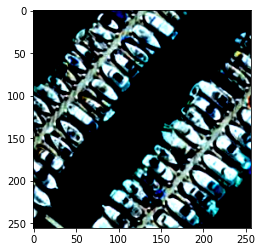


[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
<NDArray 17 @cpu(0)>
['dock', 'ship', 'water']


In [0]:
# =================== AUGMENTATION TESTER =======================
def image_with_label(a, label=None):
    img = a.asnumpy() # convert to numpy array
    img = img.transpose((1, 2, 0))  # Move channel to the last dimension

    plt.imshow(img)
    plt.show()

    if len(label) > 0:
      names = ['airplane', 'bare-soil', 'buildings',	'cars',	'chaparral',\
               'court',	'dock',	'field',	'grass',	'mobile-home',	'pavement',\
               'sand',	'sea',	'ship',	'tanks',	'trees',	'water']
      print(label)
      labs = [i for (i, v) in zip(names, label) if v]
      print(labs)


# 3x256x256
# Dataset_Single_train = Dataset_Multilabel(train_folder, Multilabels_path, n_copies=n_copies, transform=transformer)
i = mxnet.ndarray.random.randint(low=0, high=100).asscalar()
print(len(Dataset_Single_train))
print(Dataset_Single_train[i][0].shape)
image_with_label(Dataset_Single_train[i][0], Dataset_Single_train[i][1])


#### 2.2) Defining the network
We will simply use the FCN architecture seen during the lecture:

Check the output shape of the network

In [0]:
ctx = d2l.try_all_gpus()

In [0]:
net = nn.Sequential()
net.add(nn.Conv2D(channels=3, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.BatchNorm(),
        nn.Conv2D(channels=32, kernel_size=10, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.BatchNorm(),
        nn.Conv2D(channels=64, kernel_size=10, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.BatchNorm(),
        nn.Conv2D(channels=128, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.BatchNorm(),
        nn.Conv2D(channels=256, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.BatchNorm(),
        nn.Flatten(),
        
        nn.Dense(256, activation="relu"),
        nn.Dropout(0.6),
        nn.Dense(128, activation="relu"),
        nn.Dropout(0.6),
        nn.Dense(17, activation="sigmoid"))
net.initialize(init=mxnet.init.Xavier())

# Test the network shapes
X = mxnet.ndarray.random.uniform(shape=(batch_size, 3, 256, 256))
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv25 output shape:	 (64, 3, 252, 252)
pool25 output shape:	 (64, 3, 126, 126)
batchnorm20 output shape:	 (64, 3, 126, 126)
conv26 output shape:	 (64, 32, 117, 117)
pool26 output shape:	 (64, 32, 58, 58)
batchnorm21 output shape:	 (64, 32, 58, 58)
conv27 output shape:	 (64, 64, 49, 49)
pool27 output shape:	 (64, 64, 24, 24)
batchnorm22 output shape:	 (64, 64, 24, 24)
conv28 output shape:	 (64, 128, 20, 20)
pool28 output shape:	 (64, 128, 10, 10)
batchnorm23 output shape:	 (64, 128, 10, 10)
conv29 output shape:	 (64, 256, 8, 8)
pool29 output shape:	 (64, 256, 4, 4)
batchnorm24 output shape:	 (64, 256, 4, 4)
flatten5 output shape:	 (64, 4096)
dense15 output shape:	 (64, 256)
dropout8 output shape:	 (64, 256)
dense16 output shape:	 (64, 128)
dropout9 output shape:	 (64, 128)
dense17 output shape:	 (64, 17)


In [0]:
# push net to gpu
# net.collect_params().reset_ctx(ctx)
net.collect_params().initialize(force_reinit=True, ctx=ctx)


In [0]:
# Implemented as seen in Stivaktakis et al. (2019)
def acc(output, label, threshold=0.45):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, num_output) flaot32 ndarray
    # threshold: scalar
    bs = output.shape[0]
    acc = 0
    for i, batch in enumerate(output): 
        batch = batch >= threshold
        acc += sum(mxnet.ndarray.logical_and(batch, label[i])) / sum(mxnet.ndarray.logical_or(batch, label[i]))
    return (acc / bs).asscalar()

a = mxnet.nd.array([[0, 0.0, 0.5, 0, 0.5]])
b = mxnet.nd.array([[0, 0, 1, 0, 1]])

acc(a, b)

1.0

In [0]:
BCE = gluon.loss.SigmoidBCELoss(from_sigmoid=True)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.001})
num_epochs = 20
threshold = 0.45

for epoch in range(num_epochs):
    train_loss, train_acc, valid_acc = 0., 0., 0.
    tic = time.time()
    #animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],legend=['train loss', 'train acc', 'test acc'])
    count = 0
    for data, label in DataLoader_Single_train:
      # gpu compatibility
        data = gluon.utils.split_and_load(data, ctx)
        label = gluon.utils.split_and_load(label, ctx)
        # forward + backward
        with autograd.record():
            count += 1
            #if (count % 100 == 0): print(count)
            output = net(mxnet.nd.concat(*data, dim=1)) #unpack the data list
            loss = BCE(output, label[0]) #index 0 is the actual label

        loss.backward()
        # update parameters
        trainer.step(batch_size)#, ignore_stale_grad=True)
        # calculate training metrics
        train_loss += loss.mean().asscalar()
        train_acc += acc(output, label[0], threshold)
        #if (count+1) % 50 == 0: animator.add(epoch + count/len(DataLoader_Single_train),(train_loss, train_acc, None))
    # calculate validation accuracy

    for i, (val_data, val_label) in enumerate(DataLoader_Single_test):
        val_data = gluon.utils.split_and_load(val_data, ctx)
        val_label = gluon.utils.split_and_load(val_label, ctx)
        valid_acc += acc( net(mxnet.nd.concat(*val_data, dim=1) ), val_label[0], threshold)
    print("Epoch %d: loss %.3f, train acc %.3f, test acc %.3f, in %.1f sec" % (
            epoch, train_loss/len(DataLoader_Single_train), train_acc/len(DataLoader_Single_train),
            valid_acc/len(DataLoader_Single_test), time.time()-tic))

## Saving the model to a file

In [0]:
model_file_name = 'net_20200424_0115_mult1.params'
net.save_parameters(model_file_name)

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

model_file = drive.CreateFile({'title' : model_file_name})
model_file.SetContentFile(model_file_name)
model_file.Upload()

## Defining Test Metrics and Running Predictions

In [0]:
# Define more metrics
def precision(output, label, threshold=0.45):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, num_output) flaot32 ndarray
    # threshold: scalar
    bs = output.shape[0]
    prec = 0
    for i, batch in enumerate(output):
        batch = batch >= threshold
        if sum(mxnet.ndarray.logical_and(batch, label[i])) == 0:
          prec += 0
        else:
          prec += sum(mxnet.ndarray.logical_and(batch, label[i])) / sum(batch).asscalar()
    return (prec / bs).asscalar()

def recall(output, label, threshold=0.45):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, num_output) flaot32 ndarray
    # threshold: scalar
    bs = output.shape[0]
    rec = 0
    for i, batch in enumerate(output):
        batch = batch >= threshold
        rec += sum(mxnet.ndarray.logical_and(batch, label[i])) / sum(label[i])
    return (rec / bs).asscalar()

def f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall)

In [0]:
def evaluate_metrics_gpus(net, data_iter, split_f=d2l.split_batch):
    # Query the list of devices
    ctx = list(net.collect_params().values())[0].list_ctx()
    # metric = d2l.Accumulator(2)  # num_corrected_examples, num_examples
    test_acc, test_prec, test_rec = 0, 0, 0
    for features, labels in data_iter:
        X_shards, y_shards = split_f(features, labels, ctx)
        # Run in parallel
        pred_shards = [net(X_shard) for X_shard in X_shards]
        test_acc += mean([float(acc(pred_shard, y_shard)) for
                       pred_shard, y_shard in zip(
                           pred_shards, y_shards)])
        test_prec += mean([float(precision(pred_shard, y_shard)) for
                       pred_shard, y_shard in zip(
                           pred_shards, y_shards)])
        test_rec += mean([float(recall(pred_shard, y_shard)) for
                       pred_shard, y_shard in zip(
                           pred_shards, y_shards)])
    test_acc = test_acc / len(data_iter)
    test_prec = test_prec / len(data_iter)
    test_rec = test_rec / len(data_iter)
    test_f1 = f1(test_prec, test_rec)
    return test_acc, test_prec, test_rec, test_f1
  
evaluate_metrics_gpus(net, DataLoader_Single_test)

In [0]:
def minus(output, label, ctx, threshold=0.45):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, num_output) flaot32 ndarray
    # threshold: scalar
    bs = output.shape[0]
    out = mxnet.nd.zeros(output.shape[1], ctx=ctx[0])

    for i, batch in enumerate(output):
        batch = batch >= threshold
        out += mxnet.ndarray.subtract(batch, label[i])
    return (out / bs)

def calculate_class_bias(net, data_iter, split_f=d2l.split_batch, threshold=0.45, nclasses=17):    
    class_bias = []
    for features, labels in data_iter:
        features = features.copyto(ctx[0])
        labels = labels.copyto(ctx[0])
        preds = net(features)
        if len(class_bias) == 0:
          class_bias = minus(preds, labels, ctx)
        else:
          class_bias = minus(preds, labels, ctx)
    return class_bias / len(data_iter)

calculate_class_bias(net, DataLoader_Single_test)